## Trading JPM stocks with Average Directional Index Trading Strategy 

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

The average directional index, or ADX, is the primary technical indicator among the five indicators that make up a technical trading system developed by J. Welles Wilder, Jr. and is calculated using the other indicators that make up the trading system. The ADX is primarily used as an indicator of momentum, or trend strength, but the total ADX system is also used as a directional indicator.

In [42]:
today=datetime.today().strftime("%Y-%m-%d")

I will choose to do this study with JP Morgan stocks since year 2018: 

In [43]:
df = yf.download("JPM", start="2018-01-01", end=today)
data=df.copy()

[*********************100%***********************]  1 of 1 completed


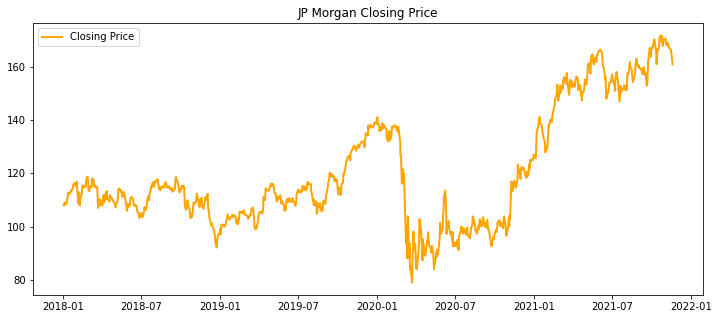

In [56]:
plt.figure(figsize=(12,5))
plt.plot(data["Close"],label="Closing Price", linewidth = 2, color = 'orange')
plt.title("JP Morgan Closing Price")
plt.legend(loc="upper left")

I will define a function to get the ADX indicator with eventually all the intermediate steps :

In [44]:
period=14
columns=["High","Low","Close"]

def ADX(data, high, low, close, column):
    
    
    for column in columns:
        prev_vals=[]
        for i in range(1,len(data[column])):
            prev_value=data[column][i-1]
            prev_vals.append(prev_value)
        data["prev_vals {}".format(column)]=np.concatenate([np.zeros(len(data["High"])-len(prev_vals)),prev_vals])
        
        True_range_indicator=[]
    for i in range(1,len(data["High"])):
        ranges=[np.abs(data[high][i]-data[low][i]),np.abs(data["prev_vals {}".format(close)][i]-data[high][i]),np.abs(data["prev_vals {}".format(close)][i]-data[low][i])]
        True_range_indicator.append(np.max(ranges))
        data["TRI"]=np.concatenate([np.zeros(len(data["High"])-len(True_range_indicator)),True_range_indicator])
        
    data["ATR_{}".format(period)]=data["TRI"].rolling(period).mean()
    DM_positive=data[high].diff()
    DM_negative=data[low].diff()
    DM_positive[DM_positive<0]=0
    DM_negative[DM_negative>0]=0
    data["dir_mov +"]=100*((DM_positive.ewm(alpha=1/period).mean())/data["ATR_{}".format(period)])
    data["dir_mov -"]=np.abs(100*((DM_negative.ewm(alpha=1/period).mean())/data["ATR_{}".format(period)]))
    data["Directional_Index"]=(np.abs(data["dir_mov +"]-data["dir_mov -"])/np.abs(data["dir_mov +"]+data["dir_mov -"]))*100
    
    ADX=[]
    for i in range(len(data["Directional_Index"])):
        ADX.append(((data["Directional_Index"][i-1]*(period-1))+data["Directional_Index"][i])/period)
    data["ADX"]=np.concatenate([np.zeros(len(data["Directional_Index"])-len(ADX)),ADX])
    data["ADX"]=data["ADX"].ewm(alpha = 1/period).mean()
        


In [45]:
ADX(data=data, high="High", low="Low", close="Close", column=columns)

Let's see how does the indicator I generated look like :

<Figure size 5040x1440 with 0 Axes>

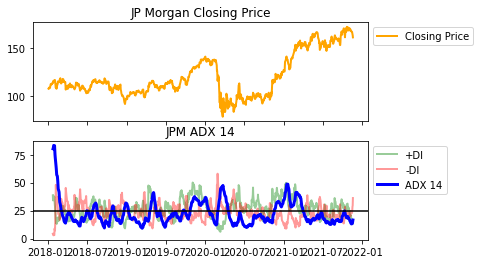

In [46]:
fig=plt.figure(figsize=(70,20))
fig,(ax1,ax2)=plt.subplots(nrows=2, sharex=True)
ax1.plot(data["Close"],label="Closing Price", linewidth = 2, color = 'orange')
ax1.set_title("JP Morgan Closing Price")
ax2.plot(data["dir_mov +"], color = 'g', label = "+DI", linewidth = 2, alpha = 0.4)
ax2.plot(data["dir_mov -"], color = 'r', label = "-DI", linewidth = 2, alpha = 0.4)
ax2.plot(data["ADX"], color = 'b', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'black')
ax1.legend(bbox_to_anchor=(1,1), loc="upper left")
ax2.legend(bbox_to_anchor=(1,1), loc="upper left")
ax2.set_title("JPM ADX 14")
plt.show()

In order to build a trading strategy with this indicator, we need to figure out when to buy or sell. These moments are directly linked with the ADX curve, which expresses ber/bull trends above a certain treshold (). The positive and negative directional movements denote which decision to take with respect to the signal occured. When the Positive Directional index is stronger (above graphically speaking) than the negartive one, it's time to buy and vice versa. Let's define a buy/sell signal function:

In [47]:
def adx_signal(data, prices, pdi, ndi, adx):
    buy_signal_price = []
    sell_signal_price = []
    signal = 0
    
    
    for i in range(len(data[prices])):
        if data[adx][i]>25 and data[adx][i-1]<25 and data[pdi][i]>data[ndi][i]:
            if signal!=1:
                buy_signal_price.append(data[prices][i])
                sell_signal_price.append(np.nan)
                signal = 1
            else:
                buy_signal_price.append(np.nan)
                sell_signal_price.append(np.nan)
        elif data[adx][i]>25 and data[adx][i-1]<25 and data[ndi][i]>data[pdi][i]:
            if signal !=-1:
                buy_signal_price.append(np.nan)
                sell_signal_price.append(data[prices][i])
                signal =-1
            else:
                buy_signal_price.append(np.nan)
                sell_signal_price.append(np.nan)
        else:
                buy_signal_price.append(np.nan)
                sell_signal_price.append(np.nan)
    return(buy_signal_price, sell_signal_price) 

In [48]:
buy_signal_price,sell_signal_price=adx_signal(data=data, prices="Close", pdi="dir_mov +", ndi="dir_mov -", adx="ADX")

Once we've implemented the function , let's take a look on the moments when the indicator suggested a buy/sell and the stock price trend that followed; we will thus have an idea about the efficiency of this indicator.

<Figure size 5040x1440 with 0 Axes>

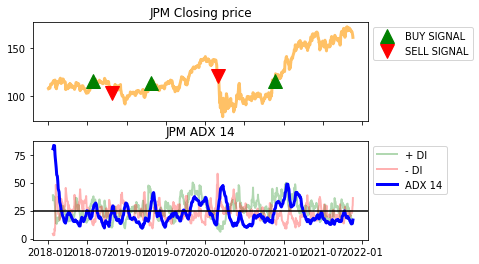

In [49]:
fig=plt.figure(figsize=(70,20))
fig,(ax1,ax2)=plt.subplots(nrows=2, sharex=True)
ax1.plot(data["Close"], linewidth = 3, color = '#ff9800', alpha = 0.6)
ax1.set_title("JPM Closing price")
ax1.plot(data.index, buy_signal_price, marker = "^", color = "g", markersize = 14, linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(data.index, sell_signal_price, marker = "v", color = "r", markersize = 14, linewidth = 0, label = 'SELL SIGNAL')
ax2.plot(data["dir_mov +"], color = "g", label = "+ DI", linewidth = 2, alpha = 0.3)
ax2.plot(data["dir_mov -"], color = "r", label = "- DI", linewidth = 2, alpha = 0.3)
ax2.plot(data["ADX"], color = "b", label = "ADX 14", linewidth = 3)
ax2.axhline(25, color = 'black')
ax1.legend(bbox_to_anchor=(1,1), loc="upper left")
ax2.legend(bbox_to_anchor=(1,1), loc="upper left")
ax2.set_title("JPM ADX 14")
plt.show()

This indicator seems successful in forecasting trends, indeed he forecasted the 3 majors trends we can see in the Closing Price.